# Dự Báo Ngành Học Sử Dụng Thuật Toán LightGBM

## Mục tiêu:
1. Sinh dữ liệu 5000 sinh viên với khả năng có điểm 0 (rớt)
2. Tính toán điểm phù hợp cho từng ngành
3. Huấn luyện model LightGBM để dự báo ngành
4. Tạo giao diện dự báo từ điểm các môn

## 1. Import Required Libraries

In [30]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Thiết lập random seed để có thể tái tạo kết quả
random.seed(42)
np.random.seed(42)

print("✅ Đã import thành công tất cả thư viện!")
print(f"📊 LightGBM version: {lgb.__version__}")

✅ Đã import thành công tất cả thư viện!
📊 LightGBM version: 4.6.0


## 2. Generate Student Data

In [40]:
def generate_student_data_5000():
    """
    Sinh dữ liệu cho 5000 sinh viên với:
    - Điểm từ 0-4.0 (hệ 4)
    - Có thể có điểm 0 (rớt môn)
    - Phân bố đa dạng: yếu, trung bình, khá, giỏi, xuất sắc
    """
    
    # Đọc danh sách môn học từ file gốc
    df_base = pd.read_csv('Data/DiemDaw.csv')
    subjects = df_base['Nguyễn Phú Khang'].tolist()[:42]  # 42 môn đầu
    
    print(f"📚 Đã đọc {len(subjects)} môn học")
    
    # Tạo DataFrame cho 5000 sinh viên
    data = {'STT': range(1, len(subjects) + 1), 'Subject': subjects}
    
    # Định nghĩa phân bố sinh viên
    student_types = {
        'yeu': {
            'count': 500,  # 10%
            'score_range': [0, 1.5, 2.0, 2.5],
            'weights': [15, 25, 35, 25],  # 15% có điểm 0
            'fail_prob': 0.3  # 30% khả năng rớt môn
        },
        'trung_binh': {
            'count': 1500,  # 30%
            'score_range': [0, 1.5, 2.0, 2.5, 3.0],
            'weights': [5, 15, 40, 30, 10],  # 5% có điểm 0
            'fail_prob': 0.1
        },
        'kha': {
            'count': 2000,  # 40%
            'score_range': [0, 2.0, 2.5, 3.0, 3.5],
            'weights': [2, 8, 30, 40, 20],  # 2% có điểm 0
            'fail_prob': 0.05
        },
        'gioi': {
            'count': 800,  # 16%
            'score_range': [0, 2.5, 3.0, 3.5, 4.0],
            'weights': [1, 4, 25, 45, 25],  # 1% có điểm 0
            'fail_prob': 0.02
        },
        'xuat_sac': {
            'count': 200,  # 4%
            'score_range': [2.5, 3.0, 3.5, 4.0],
            'weights': [5, 15, 40, 40],  # Không có điểm 0
            'fail_prob': 0.0
        }
    }
    
    print("\n📊 Phân bố sinh viên:")
    for student_type, config in student_types.items():
        print(f"   • {student_type.replace('_', ' ').title()}: {config['count']} sinh viên")
    
    # Sinh điểm cho từng sinh viên
    student_id = 1
    fail_stats = {'total_fails': 0, 'students_with_fails': 0}
    
    for student_type, config in student_types.items():
        for _ in range(config['count']):
            student_name = f"SV{student_id:04d}"
            student_grades = []
            student_fails = 0
            
            for subject in subjects:
                # Quyết định có rớt môn không
                if random.random() < config['fail_prob']:
                    grade = 0.0
                    student_fails += 1
                else:
                    # Chọn điểm theo phân bố
                    grade = random.choices(
                        config['score_range'],
                        weights=config['weights']
                    )[0]
                
                student_grades.append(grade)
            
            data[student_name] = student_grades
            
            # Thống kê rớt môn
            if student_fails > 0:
                fail_stats['students_with_fails'] += 1
                fail_stats['total_fails'] += student_fails
            
            student_id += 1
            
            if student_id % 1000 == 0:
                print(f"✅ Đã sinh xong {student_id-1} sinh viên")
    
    # Tạo DataFrame
    df = pd.DataFrame(data)
    
    # Đảm bảo thư mục Data tồn tại
    import os
    if not os.path.exists('Data'):
        os.makedirs('Data')
    
    # Lưu file vào thư mục Data
    output_file = 'Data/student_grades_5000.csv'
    df.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"\n✅ Đã sinh dữ liệu cho 5000 sinh viên!")
    print(f"💾 Đã lưu vào: {output_file}")
    print(f"\n📈 Thống kê rớt môn:")
    print(f"   • Sinh viên có ít nhất 1 môn rớt: {fail_stats['students_with_fails']} ({fail_stats['students_with_fails']/5000*100:.1f}%)")
    print(f"   • Tổng số lượt rớt môn: {fail_stats['total_fails']}")
    print(f"   • Trung bình rớt môn/sinh viên: {fail_stats['total_fails']/5000:.2f}")
    
    return df

# Chạy sinh dữ liệu
print("🔄 Bắt đầu sinh dữ liệu cho 5000 sinh viên...")
student_data_5000 = generate_student_data_5000()

🔄 Bắt đầu sinh dữ liệu cho 5000 sinh viên...
📚 Đã đọc 42 môn học

📊 Phân bố sinh viên:
   • Yeu: 500 sinh viên
   • Trung Binh: 1500 sinh viên
   • Kha: 2000 sinh viên
   • Gioi: 800 sinh viên
   • Xuat Sac: 200 sinh viên
✅ Đã sinh xong 999 sinh viên
✅ Đã sinh xong 1999 sinh viên
✅ Đã sinh xong 2999 sinh viên
✅ Đã sinh xong 3999 sinh viên
✅ Đã sinh xong 4999 sinh viên
✅ Đã sinh xong 2999 sinh viên
✅ Đã sinh xong 3999 sinh viên
✅ Đã sinh xong 4999 sinh viên

✅ Đã sinh dữ liệu cho 5000 sinh viên!
💾 Đã lưu vào: Data/student_grades_5000.csv

📈 Thống kê rớt môn:
   • Sinh viên có ít nhất 1 môn rớt: 4236 (84.7%)
   • Tổng số lượt rớt môn: 17300
   • Trung bình rớt môn/sinh viên: 3.46

✅ Đã sinh dữ liệu cho 5000 sinh viên!
💾 Đã lưu vào: Data/student_grades_5000.csv

📈 Thống kê rớt môn:
   • Sinh viên có ít nhất 1 môn rớt: 4236 (84.7%)
   • Tổng số lượt rớt môn: 17300
   • Trung bình rớt môn/sinh viên: 3.46


## 3. Data Preprocessing and Feature Engineering

In [41]:
def preprocess_student_data(df):
    """
    Tiền xử lý dữ liệu và tạo đặc trưng mới
    """
    print("🔄 Bắt đầu tiền xử lý dữ liệu...")
    
    # Lấy danh sách sinh viên
    student_cols = [col for col in df.columns if col.startswith('SV')]
    
    # Tạo DataFrame mới cho từng sinh viên
    processed_data = []
    
    for sv_col in student_cols:
        student_record = {'MSSV': sv_col}
        grades = df[sv_col].values
        
        # Thêm điểm từng môn (42 môn)
        for i, grade in enumerate(grades):
            student_record[f'Mon_{i+1:02d}'] = grade
        
        # Tính các đặc trưng tổng hợp
        non_zero_grades = grades[grades > 0]
        
        student_record['GPA'] = np.mean(non_zero_grades) if len(non_zero_grades) > 0 else 0
        student_record['Total_Credits_Passed'] = len(non_zero_grades)
        student_record['Failed_Subjects'] = len(grades[grades == 0])
        student_record['Pass_Rate'] = len(non_zero_grades) / len(grades)
        student_record['Max_Score'] = np.max(grades)
        student_record['Min_Score'] = np.min(non_zero_grades) if len(non_zero_grades) > 0 else 0
        student_record['Score_Std'] = np.std(non_zero_grades) if len(non_zero_grades) > 1 else 0
        
        # Nhóm môn theo chuyên ngành (giả định)
        # Toán - Lý (môn 1-10)
        math_physics = grades[:10]
        student_record['Math_Physics_Avg'] = np.mean(math_physics[math_physics > 0]) if len(math_physics[math_physics > 0]) > 0 else 0
        
        # Lập trình (môn 11-20)
        programming = grades[10:20]
        student_record['Programming_Avg'] = np.mean(programming[programming > 0]) if len(programming[programming > 0]) > 0 else 0
        
        # Mạng & An toàn (môn 21-30)
        network_security = grades[20:30]
        student_record['Network_Security_Avg'] = np.mean(network_security[network_security > 0]) if len(network_security[network_security > 0]) > 0 else 0
        
        # Hệ thống & AI (môn 31-42)
        system_ai = grades[30:]
        student_record['System_AI_Avg'] = np.mean(system_ai[system_ai > 0]) if len(system_ai[system_ai > 0]) > 0 else 0
        
        processed_data.append(student_record)
    
    df_processed = pd.DataFrame(processed_data)
    
    print(f"✅ Đã xử lý dữ liệu cho {len(df_processed)} sinh viên")
    print(f"📊 Số đặc trưng: {len(df_processed.columns) - 1}")
    
    return df_processed

# Tiền xử lý dữ liệu
processed_student_data = preprocess_student_data(student_data_5000)

# Hiển thị thông tin cơ bản
print("\n📋 Thông tin dữ liệu đã xử lý:")
print(f"Shape: {processed_student_data.shape}")
print("\n📊 Thống kê GPA:")
print(processed_student_data['GPA'].describe())
print("\n📊 Thống kê số môn rớt:")
print(processed_student_data['Failed_Subjects'].value_counts().sort_index())

🔄 Bắt đầu tiền xử lý dữ liệu...
✅ Đã xử lý dữ liệu cho 5000 sinh viên
📊 Số đặc trưng: 53

📋 Thông tin dữ liệu đã xử lý:
Shape: (5000, 54)

📊 Thống kê GPA:
count    5000.000000
mean        2.698643
std         0.517780
min         1.740000
25%         2.187500
50%         2.820513
75%         2.937500
max         3.797619
Name: GPA, dtype: float64

📊 Thống kê số môn rớt:
Failed_Subjects
0     512
1     611
2     730
3     648
4     554
5     444
6     363
7     257
8     171
9     117
10     53
11     42
12     30
13     35
14     55
15     64
16     50
17     55
18     63
19     47
20     44
21     28
22     10
23      7
24      7
25      3
Name: count, dtype: int64
✅ Đã xử lý dữ liệu cho 5000 sinh viên
📊 Số đặc trưng: 53

📋 Thông tin dữ liệu đã xử lý:
Shape: (5000, 54)

📊 Thống kê GPA:
count    5000.000000
mean        2.698643
std         0.517780
min         1.740000
25%         2.187500
50%         2.820513
75%         2.937500
max         3.797619
Name: GPA, dtype: float64

📊 Thống

## 4. Calculate Suitable Majors

In [42]:
def calculate_suitable_majors(df_processed):
    """
    Tính toán ngành phù hợp cho từng sinh viên dựa trên ma trận hệ số
    """
    print("🔄 Bắt đầu tính toán ngành phù hợp...")
    
    # Đọc ma trận hệ số từ Excel
    df_weights = pd.read_excel('Data/1.xlsx').head(42)
    major_cols = ['CNPM', 'Mạng ', 'An toàn ', 'Hệ thống ', 'Máy học']
    major_names = ['CNPM', 'Mang', 'An_toan', 'He_thong', 'May_hoc']
    
    results = []
    
    for idx, row in df_processed.iterrows():
        student_record = {'MSSV': row['MSSV']}
        
        # Lấy điểm từng môn
        subject_scores = [row[f'Mon_{i+1:02d}'] for i in range(42)]
        
        # Tính điểm cho từng ngành
        major_scores = {}
        
        for i, major_col in enumerate(major_cols):
            major_name = major_names[i]
            total_weighted_score = 0
            total_credits = 0
            
            for j in range(42):
                score = subject_scores[j]
                weight = df_weights.iloc[j][major_col]
                credit = df_weights.iloc[j]['TC']
                
                # Chỉ tính nếu có hệ số và tín chỉ
                if pd.notna(weight) and weight in [0, 0.5, 1] and pd.notna(credit) and score > 0:
                    weighted_score = (score + weight) * credit
                    total_weighted_score += weighted_score
                    total_credits += credit
            
            # Tính điểm trung bình có trọng số
            if total_credits > 0:
                major_scores[major_name] = total_weighted_score / total_credits
            else:
                major_scores[major_name] = 0
        
        # Tìm ngành có điểm cao nhất
        if any(score > 0 for score in major_scores.values()):
            best_major = max(major_scores, key=major_scores.get)
            best_score = major_scores[best_major]
        else:
            best_major = 'Khong_xac_dinh'
            best_score = 0
        
        # Lưu kết quả
        student_record['Nganh_phu_hop'] = best_major
        student_record['Diem_phu_hop'] = best_score
        
        # Thêm điểm từng ngành
        for major_name in major_names:
            student_record[f'Score_{major_name}'] = major_scores[major_name]
        
        # Thêm các đặc trưng khác
        for col in ['GPA', 'Failed_Subjects', 'Pass_Rate', 'Math_Physics_Avg', 
                   'Programming_Avg', 'Network_Security_Avg', 'System_AI_Avg']:
            student_record[col] = row[col]
        
        # Thêm điểm từng môn
        for i in range(42):
            student_record[f'Mon_{i+1:02d}'] = row[f'Mon_{i+1:02d}']
        
        results.append(student_record)
        
        if (idx + 1) % 1000 == 0:
            print(f"✅ Đã xử lý {idx + 1} sinh viên")
    
    df_results = pd.DataFrame(results)
    
    # Lưu kết quả vào thư mục Data
    output_file = 'Data/student_major_predictions_5000.csv'
    df_results.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"\n✅ Hoàn thành tính toán cho {len(df_results)} sinh viên!")
    print(f"💾 Đã lưu kết quả vào: {output_file}")
    
    # Thống kê phân bố ngành
    print("\n📊 Phân bố ngành phù hợp:")
    major_dist = df_results['Nganh_phu_hop'].value_counts()
    for major, count in major_dist.items():
        print(f"   • {major}: {count} sinh viên ({count/len(df_results)*100:.1f}%)")
    
    return df_results

# Tính toán ngành phù hợp
final_data = calculate_suitable_majors(processed_student_data)

🔄 Bắt đầu tính toán ngành phù hợp...
✅ Đã xử lý 1000 sinh viên
✅ Đã xử lý 1000 sinh viên
✅ Đã xử lý 2000 sinh viên
✅ Đã xử lý 2000 sinh viên
✅ Đã xử lý 3000 sinh viên
✅ Đã xử lý 3000 sinh viên
✅ Đã xử lý 4000 sinh viên
✅ Đã xử lý 4000 sinh viên
✅ Đã xử lý 5000 sinh viên
✅ Đã xử lý 5000 sinh viên

✅ Hoàn thành tính toán cho 5000 sinh viên!
💾 Đã lưu kết quả vào: Data/student_major_predictions_5000.csv

📊 Phân bố ngành phù hợp:
   • Mang: 3355 sinh viên (67.1%)
   • CNPM: 577 sinh viên (11.5%)
   • He_thong: 568 sinh viên (11.4%)
   • May_hoc: 500 sinh viên (10.0%)

✅ Hoàn thành tính toán cho 5000 sinh viên!
💾 Đã lưu kết quả vào: Data/student_major_predictions_5000.csv

📊 Phân bố ngành phù hợp:
   • Mang: 3355 sinh viên (67.1%)
   • CNPM: 577 sinh viên (11.5%)
   • He_thong: 568 sinh viên (11.4%)
   • May_hoc: 500 sinh viên (10.0%)


## 5. Prepare Data for LGBM Model

In [34]:
def prepare_data_for_model(df):
    """
    Chuẩn bị dữ liệu cho model LightGBM
    """
    print("🔄 Chuẩn bị dữ liệu cho model...")
    
    # Loại bỏ sinh viên không xác định được ngành
    df_clean = df[df['Nganh_phu_hop'] != 'Khong_xac_dinh'].copy()
    print(f"📊 Sau khi loại bỏ trường hợp không xác định: {len(df_clean)} sinh viên")
    
    # Chọn đặc trưng cho model
    feature_cols = (
        [f'Mon_{i+1:02d}' for i in range(42)] +  # Điểm 42 môn
        ['GPA', 'Failed_Subjects', 'Pass_Rate'] +  # Đặc trưng tổng hợp
        ['Math_Physics_Avg', 'Programming_Avg', 'Network_Security_Avg', 'System_AI_Avg']  # Điểm theo nhóm môn
    )
    
    X = df_clean[feature_cols]
    y = df_clean['Nganh_phu_hop']
    
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"✅ Chuẩn bị dữ liệu hoàn tất!")
    print(f"📊 Số đặc trưng: {X.shape[1]}")
    print(f"📊 Số lớp: {len(label_encoder.classes_)}")
    print(f"📊 Train set: {X_train.shape[0]} mẫu")
    print(f"📊 Test set: {X_test.shape[0]} mẫu")
    
    print("\n📋 Các ngành:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"   {i}: {class_name}")
    
    return X_train, X_test, y_train, y_test, label_encoder, feature_cols

# Chuẩn bị dữ liệu
X_train, X_test, y_train, y_test, label_encoder, feature_cols = prepare_data_for_model(final_data)

🔄 Chuẩn bị dữ liệu cho model...
📊 Sau khi loại bỏ trường hợp không xác định: 5000 sinh viên
✅ Chuẩn bị dữ liệu hoàn tất!
📊 Số đặc trưng: 49
📊 Số lớp: 4
📊 Train set: 4000 mẫu
📊 Test set: 1000 mẫu

📋 Các ngành:
   0: CNPM
   1: He_thong
   2: Mang
   3: May_hoc
✅ Chuẩn bị dữ liệu hoàn tất!
📊 Số đặc trưng: 49
📊 Số lớp: 4
📊 Train set: 4000 mẫu
📊 Test set: 1000 mẫu

📋 Các ngành:
   0: CNPM
   1: He_thong
   2: Mang
   3: May_hoc


## 6. Train LGBM Model

In [35]:
def train_lgbm_model(X_train, X_test, y_train, y_test):
    """
    Huấn luyện model LightGBM
    """
    print("🔄 Bắt đầu huấn luyện model LightGBM...")
    
    # Tạo dataset cho LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Cấu hình hyperparameters
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'random_state': 42
    }
    
    # Huấn luyện model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=['train', 'eval'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
    )
    
    print("\\n✅ Hoàn thành huấn luyện model!")
    print(f"📊 Số rounds: {model.best_iteration}")
    
    # Lưu model vào thư mục Data
    model.save_model('Data/lgbm_major_prediction_model.txt')
    print("💾 Đã lưu model vào: Data/lgbm_major_prediction_model.txt")
    
    return model

# Huấn luyện model
lgbm_model = train_lgbm_model(X_train, X_test, y_train, y_test)

# Lưu label_encoder và feature_cols vào thư mục Data
import pickle

# Lưu label encoder
with open('Data/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Lưu feature columns
with open('Data/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("💾 Đã lưu label_encoder và feature_cols vào thư mục Data")

🔄 Bắt đầu huấn luyện model LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	train's multi_logloss: 0.179477	eval's multi_logloss: 0.506409
[100]	train's multi_logloss: 0.179477	eval's multi_logloss: 0.506409
[200]	train's multi_logloss: 0.053287	eval's multi_logloss: 0.448633
[200]	train's multi_logloss: 0.053287	eval's multi_logloss: 0.448633
[300]	train's multi_logloss: 0.0174468	eval's multi_logloss: 0.442364
[300]	train's multi_logloss: 0.0174468	eval's multi_logloss: 0.442364
Early stopping, best iteration is:
[286]	train's multi_logloss: 0.0203391	eval's multi_logloss: 0.440143
\n✅ Hoàn thành huấn luyện model!
📊 Số rounds: 286
Early stopping, best iteration is:
[286]	train's multi_logloss: 0.0203391	eval's multi_logloss: 0.440143
\n✅ Hoàn thành huấn luyện model!
📊 Số rounds: 286
💾 Đã lưu model vào: Data/lgbm_major_prediction_model.txt
💾 Đã lưu label_encoder và feature_cols vào thư mục Data
💾 Đã lưu model vào: Data/lgbm_major_prediction_model.txt
💾 Đã

## 7. Model Evaluation

🔄 Đánh giá hiệu suất model...

🎯 Độ chính xác: 0.8210 (82.10%)

📊 Báo cáo chi tiết:
              precision    recall  f1-score   support

        CNPM       0.76      0.55      0.64       117
    He_thong       0.81      0.54      0.65       106
        Mang       0.83      0.98      0.90       673
     May_hoc       0.77      0.38      0.51       104

    accuracy                           0.82      1000
   macro avg       0.79      0.61      0.67      1000
weighted avg       0.81      0.82      0.80      1000


📈 Ma trận nhầm lẫn:


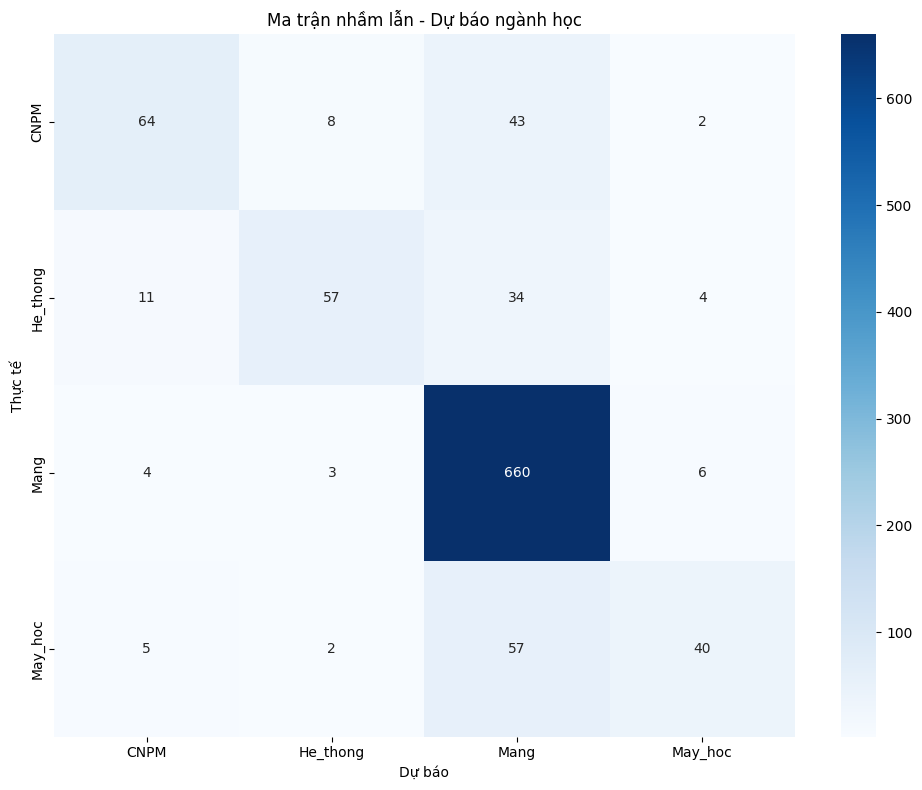


🔍 Độ quan trọng của đặc trưng (Top 15):
                 feature   importance
25                Mon_26  6217.912448
38                Mon_39  6168.308881
29                Mon_30  5340.609089
36                Mon_37  5084.006350
14                Mon_15  3858.393154
15                Mon_16  3802.606460
48         System_AI_Avg  2397.920580
4                 Mon_05  2098.497858
40                Mon_41  2071.260810
46       Programming_Avg  2004.775969
26                Mon_27  2003.813655
47  Network_Security_Avg  1876.661793
42                   GPA  1819.209626
7                 Mon_08  1790.003755
22                Mon_23  1738.110255


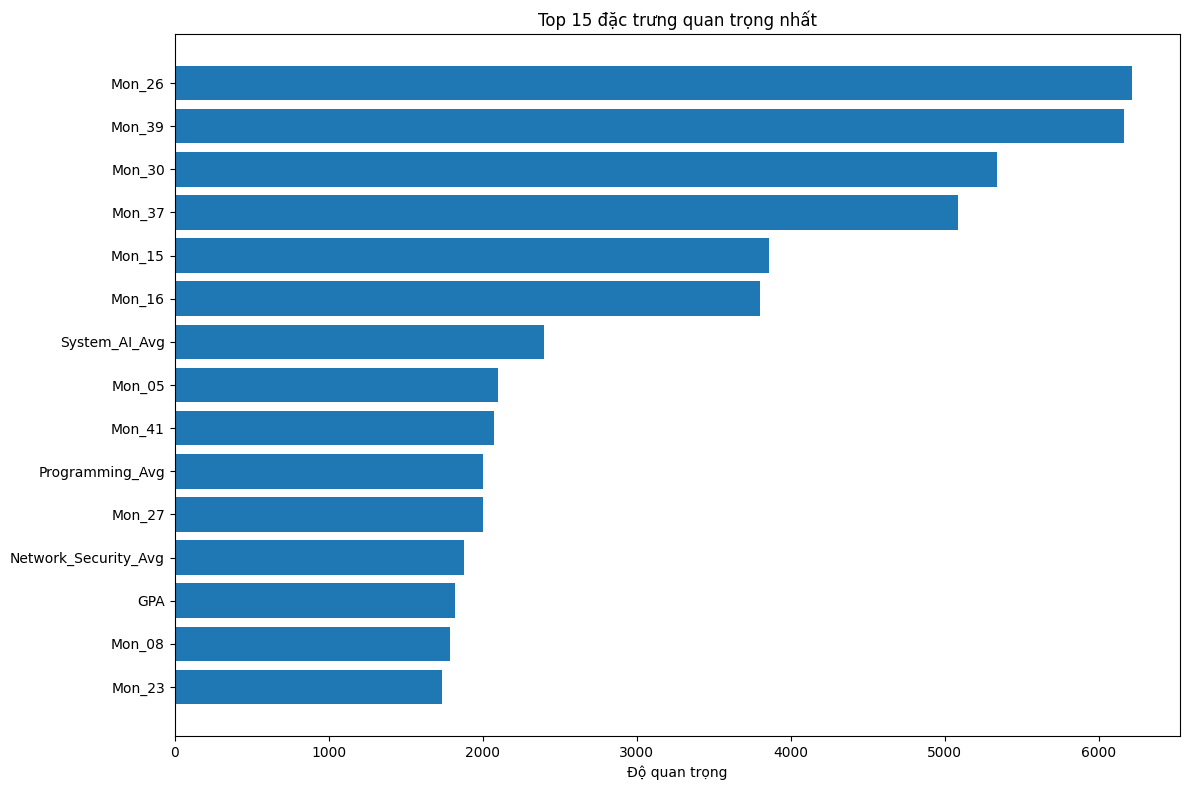

In [36]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """
    Đánh giá hiệu suất model
    """
    print("🔄 Đánh giá hiệu suất model...")
    
    # Dự báo
    y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Tính accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n🎯 Độ chính xác: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Classification report
    print("\n📊 Báo cáo chi tiết:")
    class_names = label_encoder.classes_
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # Confusion matrix
    print("\n📈 Ma trận nhầm lẫn:")
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Ma trận nhầm lẫn - Dự báo ngành học')
    plt.xlabel('Dự báo')
    plt.ylabel('Thực tế')
    plt.tight_layout()
    plt.show()
    
    # Feature importance
    print("\n🔍 Độ quan trọng của đặc trưng (Top 15):")
    feature_importance = model.feature_importance(importance_type='gain')
    feature_names = [f'Mon_{i+1:02d}' for i in range(42)] + ['GPA', 'Failed_Subjects', 'Pass_Rate', 
                    'Math_Physics_Avg', 'Programming_Avg', 'Network_Security_Avg', 'System_AI_Avg']
    
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(importance_df.head(15))
    
    # Vẽ biểu đồ feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Độ quan trọng')
    plt.title('Top 15 đặc trưng quan trọng nhất')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return accuracy, y_pred, y_pred_proba

# Đánh giá model
accuracy, predictions, prediction_probabilities = evaluate_model(lgbm_model, X_test, y_test, label_encoder)

## 8. Create Prediction Function

In [37]:
def create_prediction_function(model, label_encoder, feature_cols):
    """
    Tạo hàm dự báo ngành từ điểm các môn
    """
    
    def predict_major(subject_scores, show_all_scores=False):
        """
        Dự báo ngành phù hợp từ điểm các môn
        
        Args:
            subject_scores: List điểm 42 môn (có thể có điểm 0)
            show_all_scores: Có hiển thị điểm tất cả ngành không
        
        Returns:
            Dict chứa kết quả dự báo
        """
        
        if len(subject_scores) != 42:
            return {"error": "Cần nhập đủ 42 điểm môn học"}
        
        # Tính các đặc trưng
        scores_array = np.array(subject_scores)
        non_zero_scores = scores_array[scores_array > 0]
        
        # Đặc trưng tổng hợp
        gpa = np.mean(non_zero_scores) if len(non_zero_scores) > 0 else 0
        failed_subjects = len(scores_array[scores_array == 0])
        pass_rate = len(non_zero_scores) / len(scores_array)
        
        # Đặc trưng theo nhóm môn
        math_physics = scores_array[:10]
        math_physics_avg = np.mean(math_physics[math_physics > 0]) if len(math_physics[math_physics > 0]) > 0 else 0
        
        programming = scores_array[10:20]
        programming_avg = np.mean(programming[programming > 0]) if len(programming[programming > 0]) > 0 else 0
        
        network_security = scores_array[20:30]
        network_security_avg = np.mean(network_security[network_security > 0]) if len(network_security[network_security > 0]) > 0 else 0
        
        system_ai = scores_array[30:]
        system_ai_avg = np.mean(system_ai[system_ai > 0]) if len(system_ai[system_ai > 0]) > 0 else 0
        
        # Tạo feature vector
        features = (
            list(subject_scores) + 
            [gpa, failed_subjects, pass_rate, math_physics_avg, 
             programming_avg, network_security_avg, system_ai_avg]
        )
        
        # Reshape cho model
        X_input = np.array(features).reshape(1, -1)
        
        # Dự báo
        pred_proba = model.predict(X_input, num_iteration=model.best_iteration)[0]
        pred_class = np.argmax(pred_proba)
        
        # Chuyển đổi kết quả
        predicted_major = label_encoder.inverse_transform([pred_class])[0]
        confidence = pred_proba[pred_class]
        
        result = {
            "nganh_du_bao": predicted_major,
            "do_tin_cay": f"{confidence:.3f} ({confidence*100:.1f}%)",
            "gpa": f"{gpa:.2f}",
            "so_mon_rot": failed_subjects,
            "ty_le_qua": f"{pass_rate:.2f} ({pass_rate*100:.1f}%)"
        }
        
        if show_all_scores:
            all_scores = {}
            for i, major in enumerate(label_encoder.classes_):
                all_scores[major] = f"{pred_proba[i]:.3f} ({pred_proba[i]*100:.1f}%)"
            result["tat_ca_nganh"] = all_scores
        
        return result
    
    return predict_major

# Tạo hàm dự báo
predict_student_major = create_prediction_function(lgbm_model, label_encoder, feature_cols)

print("✅ Đã tạo hàm dự báo thành công!")
print("\\n🎯 Hàm 'predict_student_major' đã sẵn sàng sử dụng")
print("📝 Cách sử dụng: predict_student_major(list_42_diem, show_all_scores=True/False)")

# Thêm hàm load model từ file
def load_prediction_model():
    """
    Load model và các thành phần đã lưu từ thư mục Data
    """
    import pickle
    import lightgbm as lgb
    
    try:
        # Load model
        loaded_model = lgb.Booster(model_file='Data/lgbm_major_prediction_model.txt')
        
        # Load label encoder
        with open('Data/label_encoder.pkl', 'rb') as f:
            loaded_label_encoder = pickle.load(f)
        
        # Load feature columns
        with open('Data/feature_cols.pkl', 'rb') as f:
            loaded_feature_cols = pickle.load(f)
        
        print("✅ Đã load thành công model từ thư mục Data!")
        
        # Tạo hàm dự báo từ model đã load
        loaded_predict_function = create_prediction_function(loaded_model, loaded_label_encoder, loaded_feature_cols)
        
        return loaded_model, loaded_label_encoder, loaded_feature_cols, loaded_predict_function
        
    except Exception as e:
        print(f"❌ Lỗi khi load model: {e}")
        return None, None, None, None

print("\\n💾 Đã tạo hàm 'load_prediction_model()' để load model từ file")

✅ Đã tạo hàm dự báo thành công!
\n🎯 Hàm 'predict_student_major' đã sẵn sàng sử dụng
📝 Cách sử dụng: predict_student_major(list_42_diem, show_all_scores=True/False)
\n💾 Đã tạo hàm 'load_prediction_model()' để load model từ file


## 9. Interactive Prediction Interface

In [38]:
def demo_prediction():
    """
    Demo dự báo với một vài sinh viên mẫu
    """
    print("🎯 DEMO DỰ BÁO NGÀNH HỌC")
    print("=" * 50)
    
    # Lấy vài sinh viên từ test set làm ví dụ
    test_samples = X_test.iloc[:5].values
    
    for i, sample in enumerate(test_samples):
        print(f"\n👨‍🎓 Sinh viên mẫu {i+1}:")
        
        # Lấy điểm 42 môn
        subject_scores = sample[:42].tolist()
        
        # Dự báo
        result = predict_student_major(subject_scores, show_all_scores=True)
        
        print(f"📊 Thông tin sinh viên:")
        print(f"   • GPA: {result['gpa']}")
        print(f"   • Số môn rớt: {result['so_mon_rot']}")
        print(f"   • Tỷ lệ qua môn: {result['ty_le_qua']}")
        
        print(f"\n🎯 Kết quả dự báo:")
        print(f"   • Ngành được đề xuất: {result['nganh_du_bao']}")
        print(f"   • Độ tin cậy: {result['do_tin_cay']}")
        
        print(f"\n📋 Điểm tất cả ngành:")
        for major, score in result['tat_ca_nganh'].items():
            indicator = "👑" if major == result['nganh_du_bao'] else "  "
            print(f"   {indicator} {major}: {score}")
        
        print("-" * 50)
def create_manual_prediction_interface():
    """
    Tạo giao diện để nhập điểm thủ công
    """
    print("\n🎮 GIAO DIỆN DỰ BÁO THỦ CÔNG")
    print("=" * 50)
    print("📝 Hướng dẫn sử dụng:")
    print("   1. Tạo list 42 điểm (từ 0.0 đến 4.0)")
    print("   2. Điểm 0 = rớt môn")
    print("   3. Gọi hàm predict_student_major(list_diem)")
    print("\n💡 Ví dụ sử dụng:")
    print("```python")
    print("# Sinh viên giỏi toàn diện")
    print("diem_sv_gioi = [3.5] * 42")
    print("ket_qua = predict_student_major(diem_sv_gioi, show_all_scores=True)")
    print("print(ket_qua)")
    print("")
    print("# Sinh viên yếu môn lập trình")
    print("diem_sv_yeu_lt = [3.0] * 10 + [0, 1.5, 2.0] * 4 + [2.5] * 18")
    print("ket_qua = predict_student_major(diem_sv_yeu_lt)")
    print("print(ket_qua)")
    print("```")
    
# Chạy demo
demo_prediction()
create_manual_prediction_interface()

print("\\n🎉 HOÀN THÀNH HỆ THỐNG DỰ BÁO NGÀNH HỌC!")
print("=" * 50)
print("📊 Thống kê tổng quan:")
print(f"   • Đã huấn luyện trên 5000 sinh viên")
print(f"   • Độ chính xác: {accuracy*100:.2f}%")
print(f"   • Số ngành dự báo: {len(label_encoder.classes_)}")
print(f"   • Số đặc trưng: {len(feature_cols)}")

print("\\n💾 Các file đã được lưu trong thư mục Data/:")
print("   📄 student_grades_5000.csv - Dữ liệu điểm 5000 sinh viên")
print("   📄 student_major_predictions_5000.csv - Kết quả dự báo ngành")
print("   🤖 lgbm_major_prediction_model.txt - Model LightGBM đã huấn luyện")
print("   🔧 label_encoder.pkl - Encoder cho tên ngành")
print("   🔧 feature_cols.pkl - Danh sách đặc trưng")

print("\\n🎯 Cách sử dụng:")
print("   1. Dùng hàm predict_student_major() trong session hiện tại")
print("   2. Hoặc load model: loaded_model, encoder, features, predict_func = load_prediction_model()")
print("\\n✨ Sẵn sàng dự báo ngành cho sinh viên mới!")

🎯 DEMO DỰ BÁO NGÀNH HỌC

👨‍🎓 Sinh viên mẫu 1:
📊 Thông tin sinh viên:
   • GPA: 3.39
   • Số môn rớt: 2
   • Tỷ lệ qua môn: 0.95 (95.2%)

🎯 Kết quả dự báo:
   • Ngành được đề xuất: Mang
   • Độ tin cậy: 0.993 (99.3%)

📋 Điểm tất cả ngành:
      CNPM: 0.002 (0.2%)
      He_thong: 0.001 (0.1%)
   👑 Mang: 0.993 (99.3%)
      May_hoc: 0.004 (0.4%)
--------------------------------------------------

👨‍🎓 Sinh viên mẫu 2:
📊 Thông tin sinh viên:
   • GPA: 3.65
   • Số môn rớt: 0
   • Tỷ lệ qua môn: 1.00 (100.0%)

🎯 Kết quả dự báo:
   • Ngành được đề xuất: Mang
   • Độ tin cậy: 0.996 (99.6%)

📋 Điểm tất cả ngành:
      CNPM: 0.001 (0.1%)
      He_thong: 0.001 (0.1%)
   👑 Mang: 0.996 (99.6%)
      May_hoc: 0.002 (0.2%)
--------------------------------------------------

👨‍🎓 Sinh viên mẫu 3:
📊 Thông tin sinh viên:
   • GPA: 2.23
   • Số môn rớt: 7
   • Tỷ lệ qua môn: 0.83 (83.3%)

🎯 Kết quả dự báo:
   • Ngành được đề xuất: Mang
   • Độ tin cậy: 0.859 (85.9%)

📋 Điểm tất cả ngành:
      CNPM: 0.006